<a href="https://colab.research.google.com/github/olalekanowolabi64/bug-free-octo-invention/blob/master/clustering_bigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless

!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark
findspark.init()
findspark.find()

import pyspark
import numpy as np
import pandas as pd

"""#####loading the dataset#######"""

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Customer_Segmants').getOrCreate()

# Read data from CSV file
#you can download it from here:   https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/CC_GENERAL.csv
customer_df = spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True, nullValue='NULL')

customer_df.show(5)

customer_df.printSchema()

customer_df.count()

from pyspark.sql.functions import col,isnan, when, count

customer_df.na.drop().count()

customer_df.na.drop(how="any", thresh=2).show()






+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integ

In [4]:
customer_df.na.drop().count()

1411

In [5]:
from pyspark.ml.feature import Imputer

In [7]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['count_buyId', 'avg_price'], 
    outputCols=["{}_imputed".format(c) for c in ['count_buyId', 'avg_price']]
    ).setStrategy("mean")

#Add imputation cols to customer_df
customer_df2 = imputer.fit(customer_df).transform(customer_df)

customer_df2.show()

customer_df2.printSchema()


+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|
|   937|         5652|        1|     android|              39|

##from pyspark.sql import functions as F

In [8]:
from pyspark.sql import functions as F

In [9]:
##from pyspark.sql import functions as F
categories = customer_df2.select("platformType").distinct().rdd.flatMap(lambda x: x).collect()

exprs = [F.when(F.col("platformType") == category, 1).otherwise(0).alias(category)
         for category in categories]

customer_df3 = customer_df2.select( "count_hits" , "count_gameclicks" , "avg_price_imputed" ,  *exprs)

customer_df3=customer_df2.select("count_gameclicks","count_hits","avg_price_imputed")

customer_df3.show()

+----------------+----------+-----------------+
|count_gameclicks|count_hits|avg_price_imputed|
+----------------+----------+-----------------+
|              69|         8|7.214323175053155|
|              31|         5|7.214323175053155|
|              26|         2|7.214323175053155|
|              35|         4|7.214323175053155|
|              39|         0|              1.0|
|              36|         5|7.214323175053155|
|              40|         5|7.214323175053155|
|              46|         8|7.214323175053155|
|              68|         6|7.214323175053155|
|              76|         9|7.214323175053155|
|              69|         6|7.214323175053155|
|             129|         9|             10.0|
|              36|         6|7.214323175053155|
|             102|        14|              5.0|
|             102|         7|7.214323175053155|
|              63|         8|7.214323175053155|
|             141|        21|7.214323175053155|
|              39|         4|           

In [12]:
from pyspark.ml.feature import VectorAssembler
customer_df3.columns
assemble=VectorAssembler(inputCols=[
 "count_gameclicks",
 "count_hits",
 "avg_price_imputed",
 ], outputCol='features')
assembled_data=assemble.transform(customer_df3)
assembled_data.show(10)

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(20)


+----------------+----------+-----------------+--------------------+
|count_gameclicks|count_hits|avg_price_imputed|            features|
+----------------+----------+-----------------+--------------------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|
|              31|         5|7.214323175053155|[31.0,5.0,7.21432...|
|              26|         2|7.214323175053155|[26.0,2.0,7.21432...|
|              35|         4|7.214323175053155|[35.0,4.0,7.21432...|
|              39|         0|              1.0|      [39.0,0.0,1.0]|
|              36|         5|7.214323175053155|[36.0,5.0,7.21432...|
|              40|         5|7.214323175053155|[40.0,5.0,7.21432...|
|              46|         8|7.214323175053155|[46.0,8.0,7.21432...|
|              68|         6|7.214323175053155|[68.0,6.0,7.21432...|
|              76|         9|7.214323175053155|[76.0,9.0,7.21432...|
+----------------+----------+-----------------+--------------------+
only showing top 10 rows

+-------

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.7078208111490385
Silhouette Score: 0.7933619089102762
Silhouette Score: 0.7189021451892604
Silhouette Score: 0.6356434454139174
Silhouette Score: 0.6372311609806771
Silhouette Score: 0.6192124314350702
Silhouette Score: 0.5975819438567699
Silhouette Score: 0.4989328492913513


Text(0, 0.5, 'cost')

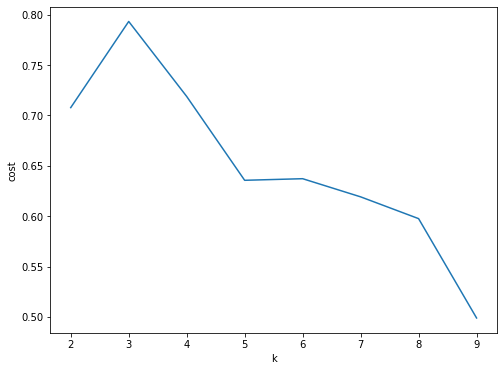

In [14]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')



+----------------+----------+-----------------+--------------------+--------------------+----------+
|count_gameclicks|count_hits|avg_price_imputed|            features|        standardized|prediction|
+----------------+----------+-----------------+--------------------+--------------------+----------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|[0.54380637390174...|         0|
+----------------+----------+-----------------+--------------------+--------------------+----------+
only showing top 1 row

+----------------+----------+-----------------+--------------------+--------------------+----------+
|count_gameclicks|count_hits|avg_price_imputed|            features|        standardized|prediction|
+----------------+----------+-----------------+--------------------+--------------------+----------+
|              69|         8|7.214323175053155|[69.0,8.0,7.21432...|[0.54380637390174...|         0|
+----------------+----------+-----------------+--------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


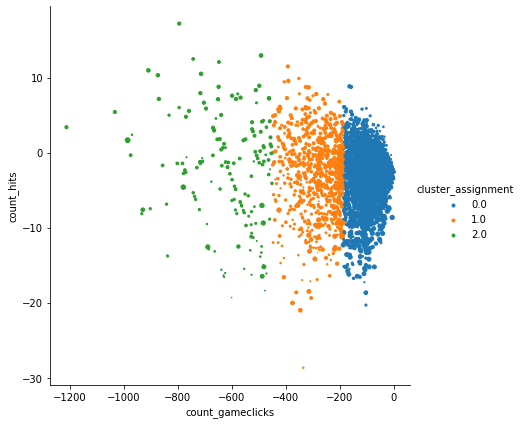

In [15]:
KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(data_scale_output)
KMeans_Assignments=KMeans_Model.transform(data_scale_output)

centers = KMeans_Model.clusterCenters()
centers

KMeans_Assignments.show(1)

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=3, inputCol="features", outputCol="prediction")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)

KMeans_Assignments.show(1)

import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.prediction).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("count_gameclicks", "count_hits","avg_price_imputed","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, 'count_gameclicks', 'count_hits','avg_price_imputed' ).add_legend()

plt.show()

In [ ]:
###Add imputation cols to df
customer_df2 = imputer.fit(customer_df).transform(customer_df)

customer_df2.show()

customer_df2.printSchema()



+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|
|   937|         5652|        1|     android|              39|

In [ ]:
#Create label whether user is a big player or small 

customer_df_players = customer_df2.withColumn('label', (customer_df2.count_gameclicks >=200).cast('integer'))

customer_df_players.show(5)



+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|    0|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|    0|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|    0|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|    0|
|   937|         565

In [ ]:
customer_df_players=customer_df_players.select("userId","userSessionId","teamLevel","platformType","count_hits","count_buyId","avg_price","count_buyId_imputed","avg_price_imputed","label")

customer_df_players.show(5)

+------+-------------+---------+------------+----------+-----------+---------+-------------------+-----------------+-----+
|userId|userSessionId|teamLevel|platformType|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|
+------+-------------+---------+------------+----------+-----------+---------+-------------------+-----------------+-----+
|   812|         5648|        1|     android|         8|       null|     null|                  1|7.214323175053155|    0|
|  1658|         5649|        1|      iphone|         5|       null|     null|                  1|7.214323175053155|    0|
|  1589|         5650|        1|      iphone|         2|       null|     null|                  1|7.214323175053155|    0|
|  1863|         5651|        1|     android|         4|       null|     null|                  1|7.214323175053155|    0|
|   937|         5652|        1|     android|         0|          1|      1.0|                  1|              1.0|    0|
+------+--------

In [ ]:
#Categorical transformation of PlatformType column to indexed numerical value

from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df_players)

# Indexer creates a new column with numeric index values
platformType_idx = indexer_model.transform(customer_df_players)


In [ ]:
# Repeat the process for the other categorical feature
#platformType_idx = StringIndexer(inputCol='platformType', outputCol='platformType_idx').fit(df_players).transform(df_players)

#Categorical transformation of  teamlevel column to indexed numerical value

from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='teamLevel', outputCol='teamLevel_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df_players)

teamLevel_idx = indexer_model.transform(customer_df_players)

#Categorical transformation of  teamlevel column to indexed numerical value

from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='userId', outputCol='userId_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df_players)
userId_idx = indexer_model.transform(customer_df_players)

#Categorical transformation of  teamlevel column to indexed numerical value


In [ ]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='userSessionId', outputCol='userSessionId_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df_players)
userSessionId_idx = indexer_model.transform(customer_df_players)

#Categorical transformation of  teamlevel column to indexed numerical value


In [ ]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='count_buyId_imputed', outputCol='count_buyId_imputed_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(customer_df_players)
count_buyId_imputed_idx = indexer_model.transform(customer_df_players)

customer_df_players.columns


['userId',
 'userSessionId',
 'teamLevel',
 'platformType',
 'count_hits',
 'count_buyId',
 'avg_price',
 'count_buyId_imputed',
 'avg_price_imputed',
 'label']

In [ ]:
#Assembling columns

from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'teamLevel', 'count_hits',
    'count_buyId_imputed', 
    'avg_price_imputed'
    
], outputCol='features')


In [ ]:
# Consolidate predictor columns
customer_assembled = assembler.transform(customer_df_players)

# Check the resulting column
customer_assembled.select('features', 'label').show(5, truncate=False)


+-------------------------------+-----+
|features                       |label|
+-------------------------------+-----+
|[1.0,8.0,1.0,7.214323175053155]|0    |
|[1.0,5.0,1.0,7.214323175053155]|0    |
|[1.0,2.0,1.0,7.214323175053155]|0    |
|[1.0,4.0,1.0,7.214323175053155]|0    |
|[1.0,0.0,1.0,1.0]              |0    |
+-------------------------------+-----+
only showing top 5 rows



In [ ]:
"""Decision Tree
Train/test split To objectively assess a Machine Learning model you need to be able to test it on an independent set of data. You can't use the same data that you used to train the model: of course the model will perform (relatively) well on those data!

You will split the data into two components:

training data (used to train the model) and testing data (used to test the model).**bold text**

"""

# Split into training and test sets in a 70:30 ratio
customers_train, customers_test = customer_assembled.randomSplit([0.8, 0.2], seed=17)

# Check that training set has around 70% of records
training_ratio = customers_train.count() / customer_assembled.count()
print(training_ratio)

customers_test.show(2)

0.6958216064083135
+------+-------------+---------+------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
|userId|userSessionId|teamLevel|platformType|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|            features|
+------+-------------+---------+------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
|     0|        23473|        1|      iphone|        28|       null|     null|                  1|7.214323175053155|    1|[1.0,28.0,1.0,7.2...|
|     1|        10041|        3|     android|         9|          2|      3.0|                  2|              3.0|    0|   [3.0,9.0,2.0,3.0]|
+------+-------------+---------+------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
only showing top 2 rows



In [ ]:
"""Build a Decision Tree
Now that you've split the data into training and testing sets, you can use the training set to fit a Decision Tree model.
"""

from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(customers_train)

tree_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2fa045972435, depth=5, numNodes=39, numClasses=2, numFeatures=4

In [ ]:
# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(customers_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

"""Evaluate the Decision Tree
You can assess the quality of your model by evaluating how well it performs on the testing data. Because the model was not trained on these data, this represents an objective assessment of the model.

A confusion matrix gives a useful breakdown of predictions versus known values. It has four cells which represent the counts of:

True Negatives (TN) — model predicts negative outcome & known outcome is negative True Positives (TP) — model predicts positive outcome & known outcome is positive False Negatives (FN) — model predicts negative outcome but known outcome is positive False Positives (FP) — model predicts positive outcome but known outcome is negative.
"""

# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1    |1.0       |[0.005454545454545455,0.9945454545454545]|
|0    |0.0       |[0.9925,0.0075]                          |
|0    |0.0       |[0.9137055837563451,0.08629441624365482] |
|0    |0.0       |[0.5764705882352941,0.4235294117647059]  |
|0    |0.0       |[0.9925,0.0075]                          |
+-----+----------+-----------------------------------------+
only showing top 5 rows

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   76|
|    0|       0.0|  934|
|    1|       1.0|  341|
|    0|       1.0|   54|
+-----+----------+-----+



In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

tree_model.featureImportances

0.9074733096085409


SparseVector(4, {0: 0.0037, 1: 0.9792, 2: 0.0071, 3: 0.0099})